# Notebook to show how to create benchmark

We will be using Playwright here.

In [1]:
from playwright.async_api import async_playwright

playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless = False)

In [2]:
import requests

import re

def extract_first_python_code(markdown_text: str):
    # Pattern to match the first ```python ``` code block
    pattern = r"```python(.*?)```"

    # Using re.DOTALL to make '.' match also newlines
    match = re.search(pattern, markdown_text, re.DOTALL)
    if match:
        # Return the first matched group, which is the code inside the ```python ```
        return match.group(1).strip()
    else:
        # Return None if no match is found
        return None

class RemoteActionEngine:
    def __init__(self, url) -> None:
        self.url = url
        
    def get_action_ground_truth(self, query: str, html: str) -> str:
        data = {
            "query": query,
            "HTML": html
        }
        endpoint = self.url + "/process_direct"
        response = requests.post(endpoint, json=data)

        if response.status_code == 200:
            code = extract_first_python_code(response.json())
            return code
        else:
            raise Exception("Failed to retrieve data, status code:", response.status_code)


    def get_action(self, query: str, html: str) -> str:
        data = {
            "query": query,
            "HTML": html
        }
        url = self.url + "/process"
        response = requests.post(url, json=data)
        
        if response.status_code == 200:
            response_data = response.json()
            code, source_nodes = response_data['code'], response_data['retrieved_nodes']
            return code, source_nodes
        else:
            raise Exception("Failed to retrieve data, status code:", response.status_code)
        
    def get_nodes(self, query: str, html: str) -> str:
        data = {
            "query": query,
            "HTML": html
        }
        url = self.url + "/get_index"
        response = requests.post(url, json=data)
        
        if response.status_code == 200:
            response_data = response.json()
            code, source_nodes = response_data['code'], response_data['retrieved_nodes']
            return code, source_nodes
        else:
            raise Exception("Failed to retrieve data, status code:", response.status_code)
        
    
    def process_fat_node(self, query: str, html: str):
        data = {
            "query": query,
            "HTML": html
        }
        url = self.url + "/process_fat_node"
        response = requests.post(url, json=data)
        
        if response.status_code == 200:
            response_data = response.json()
            code, source_nodes, metadata = response_data['code'], response_data['retrieved_nodes'], response_data['metadata']
            return code, source_nodes, metadata
        else:
            raise Exception("Failed to retrieve data, status code:", response.status_code)

In [3]:
url = "http://127.0.0.1:8000"
remote_action_engine = RemoteActionEngine(url)

In [4]:
from IPython.display import display, HTML
from bs4 import BeautifulSoup

def beautify_html(html_string):
    # Use BeautifulSoup to prettify the HTML
    soup = BeautifulSoup(html_string, 'html.parser')
    pretty_html_string = soup.prettify()
    return pretty_html_string


In [5]:
import os
from llama_index.llms.azure_openai import AzureOpenAI

api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2023-05-15"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-4"
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4-turbo")

class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=model,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0
        )
llm = LLM()

### Classification prompt

In [6]:
CLASSIFICATION_PROMPT = '''
Your goal is to assesss if for a given user query and HTML associated, the HTML contains the elements that are required to perform the action specified in the query.

To assess it, look at the presence of User-Facing Attributes, text selectors, like text="Visible Text", that could be used to uniquely identify the element requested in the query. 
You can also use Attributes like aria-label, aria-labelledby, role, etc., to target elements.
When user-facing attributes are not available or sufficient, Prefer class names and IDs that are meaningful and unlikely to change. 
Look at parent-child relationships to narrow down the element, especially when looking for elements within a specific section of the page

Answers are provided in two fields, 'Thought', which contains bullet points explaining the though process and 'Identifiable', which is a boolean indicating if the element can be identified based on the query.
---

HTML:
<div class="oyXaNc" jsaction="rcuQ6b:vZc4S;O22p3e:zjh6rb;b2trFe:eVidQc;JIbuQc:RgMCxe(YlCLKb);sPvj8e:d3sQLd;TYy3Ne:RgMCxe;" jscontroller="UmOCme" jsname="GCYh9b">
 <input jsname="DTMEae" name="entry.839337160_sentinel" type="hidden"/>
 <form action="https://docs.google.com/forms/u/0/d/e/1FAIpQLSfvfEMQPG9rMVH8p_Q_PnkffTIccd1g_VJGWmTpId5zYVhzVg/formResponse" data-clean-viewform-url="https://docs.google.com/forms/d/e/1FAIpQLSfvfEMQPG9rMVH8p_Q_PnkffTIccd1g_VJGWmTpId5zYVhzVg/viewform" data-dlp-data="%.@.null,false]" data-draft-response='%.@."",1711844705913,1711907458489,null,"8112371325920032428",null,[[null,null,["31-40"],false,null,null,839337160],[null,null,["+123"],false,null,null,1166974658],[null,null,["Daniel"],false,null,null,2005620554]]]' data-first-entry="0" data-is-first-page="true" data-last-entry="4" data-response="%.@.]" data-shuffle-seed="8112371325920032428" id="mG61Hd" jsmodel="TOfxwf Q91hve CEkLOc" method="POST" target="_self">
  <div jsaction="rcuQ6b:rcuQ6b;UxRBlf:rcuQ6b;" jscontroller="yUS4Lc">
   <div jsname="o6bZLc">
    <input name="entry.839337160" type="hidden" value="31-40"/>
    <input name="entry.1166974658" type="hidden" value="+123"/>
    <input name="entry.2005620554" type="hidden" value="Daniel"/>
    <input name="entry.1343513443" type="hidden" value=""/>
    <input name="dlut" type="hidden" value="1711907458489"/>
   </div>
  </div>
  <div class="o3Dpx" role="list">
   <div class="Qr7Oae" role="listitem">
    <div data-params='%.@.[1633920210,"Name","This is where you fill name",0,[[2005620554,null,true,null,null,null,null,null,null,null,[]]],null,null,null,null,null,null,[null,"Name"],[null,"This is where you fill name"]],"i1","i2","i3",false]' jsmodel="CP1oW">
     <div class="geS5n" jsaction="EEvAHc:yfX9oc;" jscontroller="sWGJ4b" jsname="WsjYwc">
      <div class="z12JJ">
       <div class="M4DNQ">
        <div aria-describedby="i4" aria-level="3" class="HoXoMd D1wxyf RjsPE" id="i1" role="heading">
         <span class="M7eMe">
          Name
         </span>
         <span aria-label="Required question" class="vnumgf" id="i4">
          *
         </span>
        </div>
        <div class="gubaDc OIC90c RjsPE" id="i2">
         This is where you fill name
        </div>
       </div>
      </div>
      <div class="AgroKb" jsaction="rcuQ6b:vZc4S;O22p3e:zjh6rb;b2trFe:eVidQc;sPvj8e:d3sQLd;AHmuwe:h06R8;" jscontroller="oCiKKc">
       <div class="rFrNMe k3kHxc RdH0ib yqQS1 zKHdkd CDELXb" jsaction="clickonly:KjsqPd; focus:Jt1EX; blur:fpfTEe; input:Lg5SV" jscontroller="pxq3x" jsname="YPqjbf" jsshadow="">
        <div class="aCsJod oJeWuf">
         <div class="aXBtI Wic03c">
          <div class="Xb9hP">
           <input aria-describedby="i2 i3" aria-disabled="false" aria-labelledby="i1" autocomplete="off" badinput="false" class="whsOnd zHQkBf" data-initial-dir="auto" data-initial-value="Daniel" dir="auto" jsname="YPqjbf" required="" tabindex="0" type="text"/>
           <div aria-hidden="true" class="ndJi5d snByac" jsname="LwH6nd">
            Your answer
           </div>
          </div>
          <div class="i9lrp mIZh1c">
          </div>
          <div class="OabDMe cXrdqd" jsname="XmnwAc">
          </div>
         </div>
        </div>
        <div class="LXRPh">
         <div class="ovnfwe Is7Fhb" jsname="ty6ygf">
         </div>
        </div>
       </div>
      </div>
      <div class="SL4Sz" id="i3" jsname="Rfh2Tc" role="alert">
      </div>
     </div>
    </div>
   </div>
  </div>
 </form>
</div>

Query: Select the input with placeholder 'Your answer' below 'Name', then type 'Daniel'
Thought: 
- First we need to identify the input field with the placeholder 'Your answer' that is below the 'Name' label.	
- We can use the aria-labelledby attribute to find the input field associated with the 'Name' label.
- The 'Name' label has an id of "i1", so we can use that to find the input field.
Identifiable: Yes

---

HTML:
iv class="Jwjdfe"><div class="dMALK" jsname="YlCLKb"><div role="button" class="uArJ5e UQuaGc kCyAyd" jscontroller="VXdfxd" jsaction="click:cOuCgd; mousedown:UX7yZ; mouseup:lbsD7e; mouseenter:tfO1Yc; mouseleave:JywGue;touchstart:p6p2H; touchmove:FwuNnf; touchend:yfqBxc(preventDefault=true); touchcancel:JMtRjd;focus:AHmuwe; blur:O22p3e; contextmenu:mg9Pef;" jsshadow="" tabindex="0"><div class="Fvio9d MbhUzd" jsname="ksKsZd"></div><div class="e19J0b CeoRYc"></div><span jsslot="" class="l4V7wb Fxmcue"><span class="NPEfkd RveJvd snByac">Clear selection</span></span></div></div></div></div><d
iv jsmodel="CP1oW" data-params="%.@.[1846923513,&quot;Age&quot;,null,2,[[839337160,[[&quot;18-24&quot;,null,null,null,false],[&quot;25-30&quot;,null,null,null,false],[&quot;31-40&quot;,null,null,null,false],[&quot;41-50&quot;,null,null,null,false],[&quot;51&quot;,null,null,null,false],[&quot;&quot;,null,null,null,true]],false,null,null,null,null,null,false,null,[]]],null,null,null,null,null,null,[null,&quot;Age&quot;]],&quot;i9&quot;,&quot;i10&quot;,&quot;i11&quot;,false]"><d
iv jscontroller="sWGJ4b" jsaction="EEvAHc:yfX9oc;" jsname="WsjYwc" class="geS5n"><div class="z12JJ"><div class="M4DNQ"><div id="i9" class="HoXoMd D1wxyf RjsPE" role="heading" aria-level="3"><span class="M7eMe">Age</span></div><div class="gubaDc OIC90c RjsPE" id="i10"></div></div></div><d
iv jsmodel="CP1oW" data-params="%.@.[1846923513,&quot;Age&quot;,null,2,[[839337160,[[&quot;18-24&quot;,null,null,null,false],[&quot;25-30&quot;,null,null,null,false],[&quot;31-40&quot;,null,null,null,false],[&quot;41-50&quot;,null,null,null,false],[&quot;51&quot;,null,null,null,false],[&quot;&quot;,null,null,null,true]],false,null,null,null,null,null,false,null,[]]],null,null,null,null,null,null,[null,&quot;Age&quot;]],&quot;i9&quot;,&quot;i10&quot;,&quot;i11&quot;,false]"><d
iv jscontroller="sWGJ4b" jsaction="EEvAHc:yfX9oc;" jsname="WsjYwc" class="geS5n"><div class="z12JJ"><div class="M4DNQ"><div id="i9" class="HoXoMd D1wxyf RjsPE" role="heading" aria-level="3"><span class="M7eMe">Age</span></div><div class="gubaDc OIC90c RjsPE" id="i10"></div></div></div><d

Query: "Select the radio button with label 'Other' under the 'Age' section, then type '16'"
Thought:
- The query asks to select a radio button with the label 'Other' under the 'Age' section and then type '16'.
- The provided HTML snippet shows a structure that seems to be part of a form, but the snippet is incomplete and improperly formatted (e.g., "iv" instead of "div" at the beginning).
- There is no visible radio button or input field with the label 'Other' in the provided HTML snippet.
- The 'Age' section is identified with an id of "i9", but there are no radio buttons or options listed in the snippet.
- The action of typing '16' suggests that there should be a text input field associated with the 'Other' radio button, but this is not present in the snippet.
- Without the complete and properly formatted HTML, it is not possible to determine if the 'Other' radio button exists or where to type '16'.

Identifiable: No

HTML:
{context_str}
Query: {query_str}
Thought:
Identifiable: 
'''

In [7]:
DEFAULT_PLAYWRIGHT_PROMPT = '''
Your goal is to write Playwright Python code to answer queries.

Your answer must be a Python markdown only.

Prefer User-Facing Attributes, Use text selectors, like text="Visible Text", to target elements by their visible text. 
You can also use Attributes like aria-label, aria-labelledby, role, etc., to target elements.
When user-facing attributes are not available or sufficient, Prefer class names and IDs that are meaningful and unlikely to change. 
Avoid using automatically generated, framework-specific, or obfuscated classes.
Utilize parent-child relationships to narrow down the element, especially when looking for elements within a specific section of the page

You can assume the following code has been executed:
```python
from playwright.async_api import async_playwright

playwright = await async_playwright().start()
browser = await playwright.chromium.connect_over_cdp("http://localhost:9222")
default_context = browser.contexts[0]

# Retrieve the first page in the context.
page = default_context.pages[0]
```

---

HTML:
<!DOCTYPE html>
<html>
<head>
    <title>Mock Search Page</title>
</head>
<body>
    <h1>Search Page Example</h1>
    <input id="searchBar" type="text" placeholder="Type here to search...">
    <button id="searchButton">Search</button>
    <script>
        document.getElementById('searchButton').onclick = function() {{
            var searchText = document.getElementById('searchBar').value;
            alert("Searching for: " + searchText);
        }};
    </script>
</body>
</html>

Query: Click on the search bar 'Type here to search...', type 'selenium', and press the 'Enter' key

Completion:
```python
# Let's proceed step by step.
# First we need to identify the component first, then we can click on it.

# Based on the HTML, the link can be uniquely identified using the ID "searchBar"
# Click on the search bar
search_bar = page.locator('#searchBar').first
await search_bar.click()

# Type 'selenium' into the search bar
await search_bar.type('selenium')

# Press the 'Enter' key
await page.keyboard.press('Enter')

```

---

HTML:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Mock Page for Selenium</title>
</head>
<body>
    <h1>Welcome to the Mock Page</h1>
    <div id="links">
        <a href="#link1" id="link1">Link 1</a>
        <br>
        <a href="#link2" class="link">Link 2</a>
        <br>
    </div>
</body>
</html>

Query: Click on the title Link 1 and then click on the title Link 2

Completion:
```python
# Let's proceed step by step.
# First we need to identify the first component, then we can click on it. Then we can identify the second component and click on it.

# Based on the HTML, the first link the link can be uniquely identified using the ID "link1"
# Let's use this ID with playwright to identify the link
link1 = page.locator('#link1').first

# Then we click on the link
await link1.click()

# The other link can be uniquely identified using the class "link"
# Let's use this class to identify the link
link2 = page.locator('.link').first

# Click on the element found
await link2.click()
```

---

HTML:
<!DOCTYPE html>
<html>
<head>
    <title>Mock Page</title>
</head>
<body>
    <p id="para1">This is the first paragraph.</p>
    <p id="para2">This is the second paragraph.</p>
    <p id="para3">This is the third paragraph, which we will select and copy.</p>
    <p id="para4">This is the fourth paragraph.</p>
</body>
</html>

Query: Select the text inside the third paragraph

Completion:
```python
# Let's proceed step by step.

# Select the third paragraph element
third_paragraph = page.locator("(//p)[3]").first
# Get the text inside the third paragraph
text = third_paragraph.inner_text()
```

---

HTML:

Query: Scroll up a bit

Completion:
```python
# Let's proceed step by step.
# We don't need to use the HTML data as this is a stateless operation.
# 200 pixels should be sufficient. Let's execute the JavaScript to scroll up.

await page.evaluate("window.scrollBy(0, 200)")
```

---

---

HTML:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Enhanced Mock Page for Selenium Testing</title>
</head>
<body>
    <h1>Enhanced Test Page for Selenium</h1>
    <div class="container">
        <button id="firstButton" onclick="alert('First button clicked!');">First Button</button>
        <!-- This is the button we're targeting with the class name "action-btn" -->
        <button class="action-btn" onclick="alert('Action button clicked!');">Action Button</button>
        <div class="nested-container">
            <button id="testButton" onclick="alert('Test Button clicked!');">Test Button</button>
        </div>
        <button class="hidden" onclick="alert('Hidden button clicked!');">Hidden Button</button>
    </div>
</body>
</html>


Query: Click on the Button 'Action Button'

Completion:
```python
# Let's proceed step by step.
# First we need to identify the button first, then we can click on it.

# Based on the HTML provided, we need to devise the best strategy to select the button.
# The action button can be identified using the class name "action-btn"
action_button = page.locator('.action-btn').first

# Then we can click on it
await action_button.click()
```

---

HTML:
{context_str}
Query: {query_str}
Completion:
'''

## Load dataset

In [8]:
import pandas as pd 
import asyncio
from IPython.display import display, Code, HTML

df = pd.read_csv("mind2web_extension_test.csv")
df

,split,annotation_uid,confirmed_task,raw_html,cleaned_html,action_uid,operation,code,cur_actions_desc,cur_actions_reprs,pos_candidates,prev_actions_desc,prev_actions_reprs
0,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""257"">\n <body backend_...",e14c7a5b-64cb-4dd7-bf02-716e87b41383,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,"Click on the ""Baby Names"" link.",[link] BABY NAMES -> CLICK,"[{'attributes': '{""backend_node_id"": ""217"", ""b...",NaN,NaN
1,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""7164"">\n <body backend...",4545a461-65d2-45d5-99c5-b7a9c12729f7,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,"Select the ""Female"" option.",[radio] Female -> CLICK,"[{'attributes': '{""backend_node_id"": ""7123"", ""...","['Click on the ""Baby Names"" link.']",['[link] BABY NAMES -> CLICK']
2,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""14435"">\n <body backen...",b10a178e-d5e4-43f7-b284-467a60e2752a,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,"Click on the ""Search Baby Names"" button.",[button] SEARCH BABY NAMES -> CLICK,"[{'attributes': '{""backend_node_id"": ""15270"", ...","['Click on the ""Baby Names"" link.', 'Select th...","['[link] BABY NAMES -> CLICK', '[radio] Fema..."
3,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""21515"">\n <body backen...",e93ccd55-8000-4495-85a8-91bb85f581c4,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,Click on the option for the current most popul...,[svg] -> CLICK,"[{'attributes': '{""backend_node_id"": ""21528"", ...","['Click on the ""Baby Names"" link.', 'Select th...","['[link] BABY NAMES -> CLICK', '[radio] Fema..."
4,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""37490"">\n <body backen...",ea79a86d-85b3-4b7e-bf3a-b9a13714da8b,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,"Click on the ""Most popular"" menu item.",[menuitem] Most popular -> CLICK,"[{'attributes': '{""backend_node_id"": ""37562"", ...","['Click on the ""Baby Names"" link.', 'Select th...","['[link] BABY NAMES -> CLICK', '[radio] Fema..."
5,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""52850"">\n <body backen...",56bfbbbc-9ddc-4fd5-802a-c004b1e0dcef,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,"Click on the link for the name ""Emma"".",[link] girl Emma -> CLICK,"[{'attributes': '{""backend_node_id"": ""53712"", ...","['Click on the ""Baby Names"" link.', 'Select th...","['[link] BABY NAMES -> CLICK', '[radio] Fema..."
6,test_domain,2e620aae-0a10-4c73-b1fb-d53c06a28307,Show me the popularity in 2015 of the current ...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.0 Tr...","<html backend_node_id=""67853"">\n <body backen...",780ba816-bcb4-4544-8bf4-460dff2ddbef,"{'op': 'CLICK', 'original_op': 'CLICK', 'value...",```python\nelement = driver.find_element(By.XP...,Scroll down to the item for Emma's name popula...,[link] Emma name popularity scroll down to it...,"[{'attributes': '{""backend_node_id"": ""67923"", ...","['Click

## Selenium

In [67]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()

homedir = os.path.expanduser("~")
chrome_options.binary_location = f"{homedir}/chrome-linux64/chrome"
webdriver_service = Service(f"{homedir}/chromedriver-linux64/chromedriver")

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

In [66]:


outputs = []

instruction = query

code, source_nodes, metadata = remote_action_engine.process_fat_node(query, html)

retrieve_code = metadata['retrieve_code']
indexing_time = metadata['indexing_time']
completion_time = metadata['completion_time']
model_id = metadata['model_id']
prompt = metadata['prompt']

context_str = "\n".join(source_nodes)

print("Code code:")
display(Code(code, language='python'))


try:
    exec(code)
    execution_success = True
    execution_error = ""
    identification_result = ""
except Exception as e:
    print("Error occurred:", e)
    execution_success = False
    execution_error = str(e)
    
    identification_prompt = CLASSIFICATION_PROMPT.format(query_str=instruction, context_str=context_str)
    identification_result = llm.complete(identification_prompt).text
    
    # for i, node in enumerate(source_nodes):
    #     display(Markdown(f"### Node {i+1}"))
    #     display(Code(beautify_html(node), language='html'))
    #     display(HTML(node))

output = {
    "url": url,
    "html": html,
    "source_nodes": ("-"*10).join(source_nodes),
    "query": query,
    "prompt": prompt,
    "code": code,
    "execution_success": execution_success,
    "execution_error": execution_error,
    "identification_result": identification_result,
    "model_id": model_id,
    "retrieve_code": retrieve_code,
    "indexing_time": indexing_time,
    "completion_time": completion_time
}
outputs.append(output)
driver.close()

Code code:


# Let's proceed step by step.
# First we need to identify the "Baby Names" link, then we can click on it.

# Based on the HTML provided, we can identify the "Baby Names" link by the text content within the <text> element.
# We will use an XPath expression that targets the <text> element with the exact content "Baby Names" and then navigate to the parent <button> element to click on it.

baby_names_button = driver.find_element(By.XPATH, "//text[normalize-space()='Baby Names']/ancestor::button")

# Then we can click on the button
baby_names_button.click()

Error occurred: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//text[normalize-space()='Baby Names']/ancestor::button"}
  (Session info: chrome=122.0.6261.69); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x56152897d793 <unknown>
#1 0x5615286711c6 <unknown>
#2 0x5615286bc358 <unknown>
#3 0x5615286bc411 <unknown>
#4 0x5615286ff934 <unknown>
#5 0x5615286de3fd <unknown>
#6 0x5615286fcdd9 <unknown>
#7 0x5615286de173 <unknown>
#8 0x5615286af2d3 <unknown>
#9 0x5615286afc9e <unknown>
#10 0x5615289418cb <unknown>
#11 0x561528945745 <unknown>
#12 0x56152892e2e1 <unknown>
#13 0x5615289462d2 <unknown>
#14 0x56152891217f <unknown>
#15 0x56152896bdc8 <unknown>
#16 0x56152896bfc3 <unknown>
#17 0x56152897c944 <unknown>
#18 0x7f6a76351609 start_thread



## Playwright

In [9]:
import numpy as np

def longest_common_substring(s1, s2):
    m, n = len(s1), len(s2)
    dp = [[0] * (n+1) for _ in range(m+1)]  # DP table
    longest, end_pos = 0, 0
    
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
                if dp[i][j] > longest:
                    longest = dp[i][j]
                    end_pos = i
            else:
                dp[i][j] = 0
    return longest, s1[end_pos-longest: end_pos]

def compute_lcs_scores(true_node, output_node):
    lcs_length, longest = longest_common_substring(true_node, output_node)
    true_node_score = lcs_length / len(true_node)
    output_node_score = lcs_length / len(output_node)
    return np.array([true_node_score, output_node_score])

import ast
from playwright.async_api import Locator

import re

def keep_assignments(code_snippet):
    # Regex to match variable assignments. This pattern assumes variable names are valid Python identifiers
    # and captures typical assignment statements, excluding those that might appear in comments or strings.
    pattern = r'^\s*[a-zA-Z_][a-zA-Z0-9_]*\s*=\s*.+'

    # Filter and keep only lines with variable assignments
    assignments = [line for line in code_snippet.split('\n') if re.match(pattern, line)]

    # Join the filtered lines back into a string
    return "\n".join(assignments)

# This function will be used to visit each node in the AST
class VariableVisitor(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.output = []
    
    def visit_Assign(self, node):
        
        # For each assignment, print the targets (variables)
        for target in node.targets:
            if isinstance(target, ast.Name):  # Ensure it's a variable assignment
                self.output.append(target.id)

In [30]:
from IPython.display import display, Code, HTML
import asyncio
from tqdm import tqdm

outputs = []

N_rows = 10

for index, row in tqdm(df.iloc[:N_rows].iterrows()):
    
    ground_truth_code = row["code"]
    html = row["cleaned_html"]
    query = row["cur_actions_desc"]
    
    page = await browser.new_page()
    page.set_default_timeout(5000)
    await page.set_content(html)

    instruction = query

    generated_code, source_nodes, metadata = remote_action_engine.process_fat_node(query, html)

    retrieve_code = metadata['retrieve_code']
    indexing_time = metadata['indexing_time']
    completion_time = metadata['completion_time']
    model_id = metadata['model_id']
    prompt = metadata['prompt']

    context_str = "\n".join(source_nodes)

    # Executes async the generated code
    code = keep_assignments(generated_code)
    parsed_code = ast.parse(code)

    # Create a visitor instance and use it to visit the nodes in the parsed AST
    visitor = VariableVisitor()
    visitor.visit(parsed_code)
    variables = visitor.output
    variable = variables[0]
    
    test_func = None
    indented_code = f"async def test_func():\n"

    ground_truth_code = row["code"]

    backend_node_id = ground_truth_code.split("backend_node_id")[1].split("']")[0].replace("='","")

    ground_truth_element_str = f"""
    \t{code}
    \tground_truth_element= page.locator('//*[@backend_node_id="{backend_node_id}"]')
    \tground_truth_outer_html = await ground_truth_element.evaluate("el => el.outerHTML")
    \ttarget_outer_html = await {variable}.evaluate("el => el.outerHTML")
    \tscore = max(compute_lcs_scores(ground_truth_outer_html, target_outer_html))
    \treturn score
    """

    indented_code += ground_truth_element_str
    exec(indented_code, globals())
    loop = asyncio.get_event_loop()

    if test_func:
        try:
            score = await loop.create_task(test_func())
            execution_success = True
            execution_error = ""
            identification_result = ""
        except Exception as e:
            score = None
            print("Error occurred:", e)
            execution_success = False
            execution_error = str(e)
            
            identification_prompt = CLASSIFICATION_PROMPT.format(query_str=instruction, context_str=context_str)
            identification_result = llm.complete(identification_prompt).text
            
            # for i, node in enumerate(source_nodes):
            #     display(Markdown(f"### Node {i+1}"))
            #     display(Code(beautify_html(node), language='html'))
            #     display(HTML(node))
    else:
        raise Exception("test_func not defined, issue generating code")
    output = {
        "query": query,
        "score": score,
        "html": html,
        "source_nodes": ("-"*10).join(source_nodes),
        "prompt": prompt,
        "generated_code": code,
        "ground_truth_code": f"""page.locator('//*[@backend_node_id="{backend_node_id}"]')""",
        "execution_success": execution_success,
        "execution_error": execution_error,
        "identification_result": identification_result,
        "model_id": model_id,
        "retrieve_code": retrieve_code,
        "indexing_time": indexing_time,
        "completion_time": completion_time
    }
    outputs.append(output)
    await page.close()

10it [00:35,  3.59s/it]


In [31]:
output_df = pd.DataFrame(outputs)
output_df

,query,score,html,source_nodes,prompt,generated_code,ground_truth_code,execution_success,execution_error,identification_result,model_id,retrieve_code,indexing_time,completion_time
0,"Click on the ""Baby Names"" link.",1.000000,"<html backend_node_id=""257"">\n <body backend_...","<li backend_node_id=""593"">\n ...",\nYour goal is to write Playwright Python code...,"baby_names_link = page.locator('text=""Baby Nam...","page.locator('//*[@backend_node_id=""217""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.072656,1.033828
1,"Select the ""Female"" option.",1.000000,"<html backend_node_id=""7164"">\n <body backend...","<div backend_node_id=""7932"">\n ...",\nYour goal is to write Playwright Python code...,female_radio_button = page.locator('[aria_labe...,"page.locator('//*[@backend_node_id=""7123""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.053394,0.984049
2,"Click on the ""Search Baby Names"" button.",1.000000,"<html backend_node_id=""14435"">\n <body backen...","<div backend_node_id=""15425"">\n ...",\nYour goal is to write Playwright Python code...,"search_button = page.locator('text=""Search bab...","page.locator('//*[@backend_node_id=""15270""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.040966,0.836087
3,Click on the option for the current most popul...,0.428571,"<html backend_node_id=""21515"">\n <body backen...","<li backend_node_id=""21980"">\n ...",\nYour goal is to write Playwright Python code...,"most_popular_option = page.locator('text=""Most...","page.locator('//*[@backend_node_id=""21528""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.660479,1.005223
4,"Click on the ""Most popular"" menu item.",0.469388,"<html backend_node_id=""37490"">\n <body backen...","<div backend_node_id=""44131"">\n <div back...",\nYour goal is to write Playwright Python code...,"most_popular_menu_item = page.locator('text=""M...","page.locator('//*[@backend_node_id=""37562""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.700078,0.854513
5,"Click on the link for the name ""Emma"".",1.000000,"<html backend_node_id=""52850"">\n <body backen...","<div backend_node_id=""52958"">\n ...",\nYour goal is to write Playwright Python code...,"emma_link = page.locator('text=""Emma""').first","page.locator('//*[@backend_node_id=""53712""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.697294,0.741797
6,Scroll down to the item for Emma's name popula...,1.000000,"<html backend_node_id=""67853"">\n <body backen...","<li backend_node_id=""68721"">\n ...",\nYour goal is to write Playwright Python code...,"emma_popularity = page.locator('text=""Emma nam...","page.locator('//*[@backend_node_id=""67923""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.127846,1.221751
7,Click on the button without label.,1.000000,"<html backend_node_id=""77243"">\n <body backen...","<h2 backend_node_id=""78192"">\n ...",\nYour goal is to write Playwright Python code...,button_without_label = page.locator('div[role=...,"page.locator('//*[@backend_node_id=""77310""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.133080,0.806199
8,Select the option for the year 2015.,1.000000,"<html backend_node_id=""87160"">\n <body backen...","<ul backend_node_id=""90564"" role=""listbox"">\n ...",\nYour goal is to write Playwright Python code...,"year_2015_option = page.locator('text=""2015""')...","page.locator('//*[@backend_node_id=""87226""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.210813,1.109300
9,"Type ""dermatologist"" into the search box for c...",1.000000,"<html backend_node_id=""111"">\n <body backend_...","<div backend_node_id=""248"">\n ...",\nYour goal is to write Playwright Python code...,"search_box = page.locator('input[name=""patient...","page.locator('//*[@backend_node_id=""96""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed

In [32]:
error_df = output_df.loc[output_df.score < 1.0]
error_df

,query,score,html,source_nodes,prompt,generated_code,ground_truth_code,execution_success,execution_error,identification_result,model_id,retrieve_code,indexing_time,completion_time
3,Click on the option for the current most popul...,0.428571,"<html backend_node_id=""21515"">\n <body backen...","<li backend_node_id=""21980"">\n ...",\nYour goal is to write Playwright Python code...,"most_popular_option = page.locator('text=""Most...","page.locator('//*[@backend_node_id=""21528""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.660479,1.005223
4,"Click on the ""Most popular"" menu item.",0.469388,"<html backend_node_id=""37490"">\n <body backen...","<div backend_node_id=""44131"">\n <div back...",\nYour goal is to write Playwright Python code...,"most_popular_menu_item = page.locator('text=""M...","page.locator('//*[@backend_node_id=""37562""]')",True,,,gpt-35-turbo,"def get_retriever_code(embed, html):\n \n ...",1.700078,0.854513


In [33]:
from playwright.sync_api import ElementHandle

async def toggle_highlight(element: ElementHandle, highlight: bool):
    """Highlight or unhighlight the element on the page."""
    if highlight:
        # Apply CSS styles to highlight the element
        await element.evaluate('''(element) => {
            element.style.outline = "10px dashed blue";
            element.style.backgroundColor = "rgba(135, 206, 250, 0.3)";
            element.style.borderRadius = "50px";
        }''')
    else:
        # Reset CSS styles to remove the highlight
        await element.evaluate('''(element) => {
            element.style.outline = "";
            element.style.backgroundColor = "";
            element.style.borderRadius = "";
        }''')
    return True

In [34]:
for index, row in error_df.iterrows():
    html = row["html"]
    page = await browser.new_page()
    page.set_default_timeout(5000)
    await page.set_content(html)

    generated_code = row["generated_code"]
    ground_truth_code = row["ground_truth_code"]

    print(generated_code)
    print(ground_truth_code)

most_popular_option = page.locator('text="Most popular"').first
page.locator('//*[@backend_node_id="21528"]')
most_popular_menu_item = page.locator('text="Most popular"').first
page.locator('//*[@backend_node_id="37562"]')


most_popular_menu_item


In [44]:
variable = generated_code.split(" =")[0]
value = generated_code.split("= ")[1]

test_func = None
indented_code = f"async def test_func():\n"

ground_truth_element_str = f"""
\ttarget_element = {value}
\tawait toggle_highlight(target_element, highlight=True)
\tawait target_element.scroll_into_view_if_needed()
\tawait page.screenshot(path="screenshot1.png")
\tground_truth_element= {ground_truth_code}
\tawait ground_truth_element.scroll_into_view_if_needed()
\tawait toggle_highlight(target_element, highlight=True)
\tawait page.screenshot(path="screenshot2.png")
"""

indented_code += ground_truth_element_str
exec(indented_code, globals())
loop = asyncio.get_event_loop()

await loop.create_task(test_func())

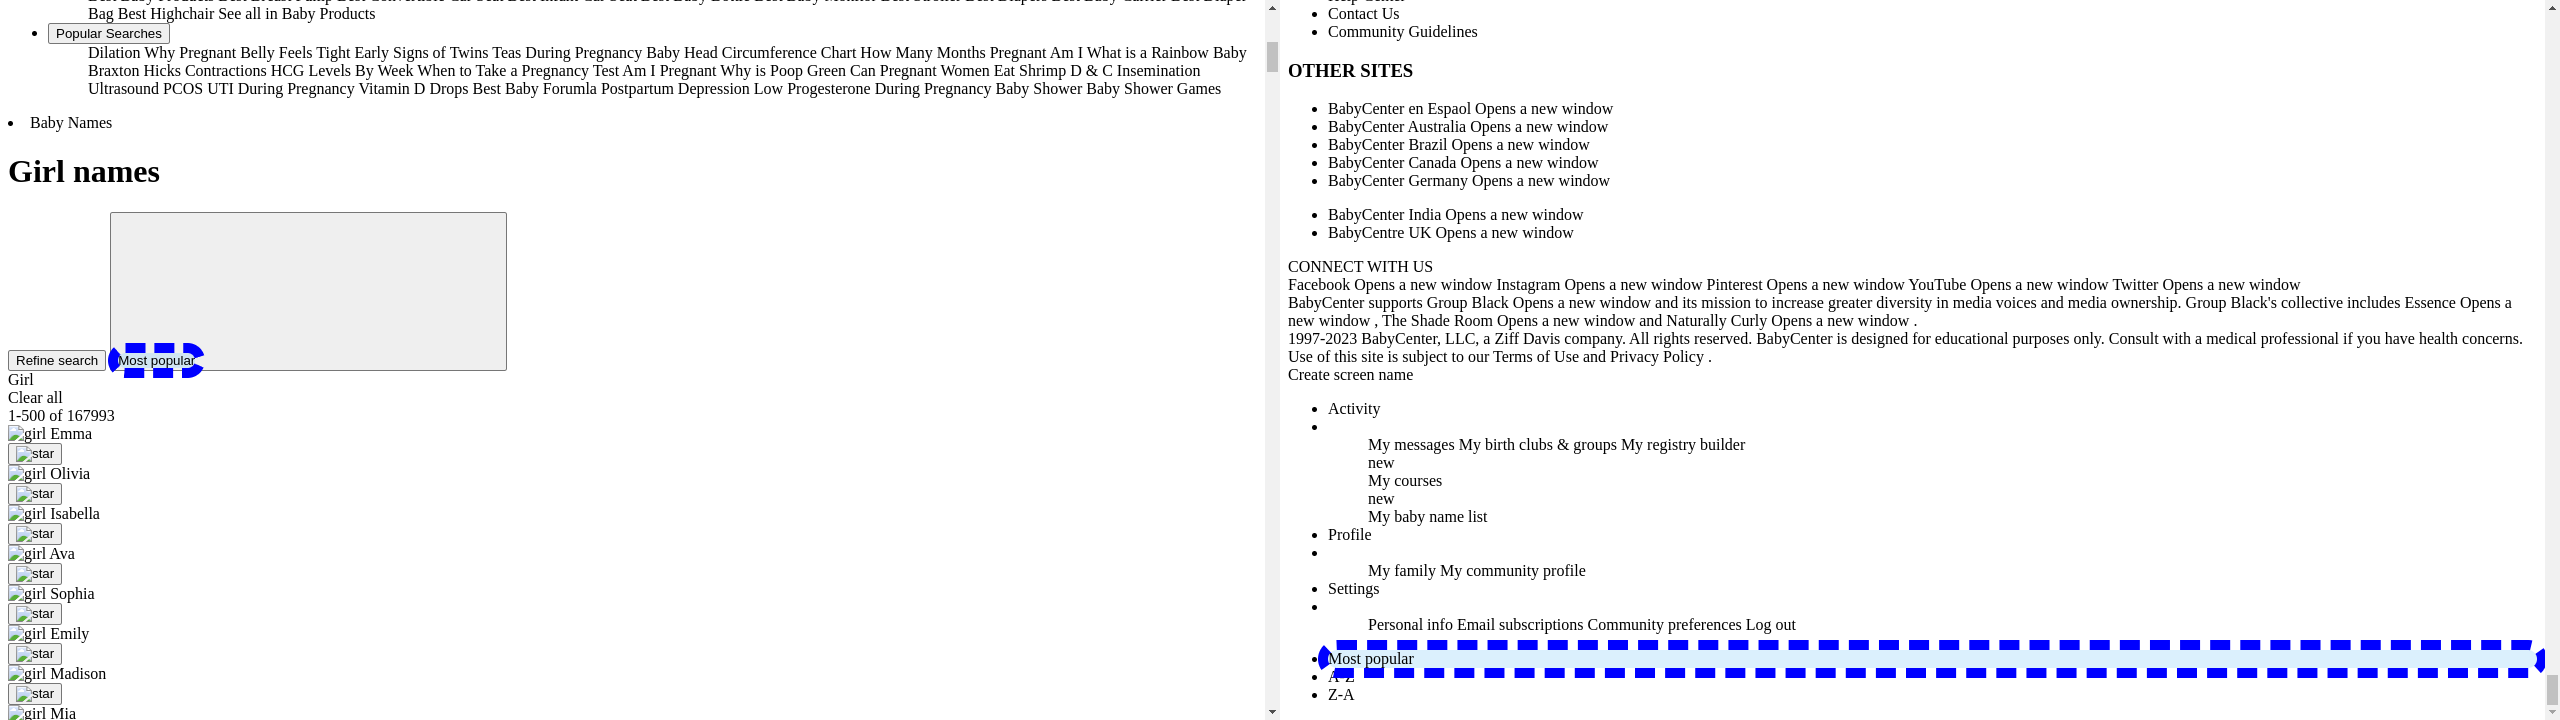

In [49]:
def combine_screenshots(output_path="combined_screenshot.png"):
    from PIL import Image, ImageDraw, ImageFont

    # Load the images
    image1 = Image.open("screenshot1.png")
    image2 = Image.open("screenshot2.png")
    
    # Calculate dimensions for the combined image
    total_width = image1.width + image2.width
    max_height = max(image1.height, image2.height)
    
    # Create a new blank image with the correct size
    combined_image = Image.new('RGB', (total_width, max_height))
    
    # Paste the original images into the combined image
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))
    
    draw = ImageDraw.Draw(combined_image)
    font = ImageFont.load_default()  # Load default font
    draw.text((10, 10), "Targeted element", fill="black", font=font)
    draw.text((image1.width + 10, 10), "Ground truth", fill="black", font=font)

    
    # Save the combined image
    combined_image.save(output_path)

from IPython.display import Image, display

display(Image("combined_screenshot.png"))